# 21 Buttons Recommender system

This notebook present the solution of item recommender problem proposed by 21Buttons about collaborative filtering.

This notebook consists in 3 parts:
    1. Prepare data for modelling
    2. Memory based approach: Item-item collaborative filtering
    3. Model based approach: Using Implicit package. Alternative Least Squares for Matrix factorization
    4. Conclusions and final similar items

## 1 - Preparing data

This section includes:
    * Load data and define rmse function
    * Divide dataset into train and test sets
    * Treatment of data to convert dataset into user-item matrix
    * Normalize de matrix

### 1.1 - Load data

In [1]:
# Import libraries
import pandas as pd
import numpy as np

from scipy import sparse
from numpy import linalg as LA
from math import sqrt

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import implicit

In [2]:
# Load dataset
data = pd.read_csv('21B_tag_views_dataset.csv', encoding='ansi')
data.head()

,id,user_id,tag_id,product_name
0,1,00000055a78bf6735c4a89358fab1de34104c3cb,e78de9dad70d230a096f0bbdc3e89b5cae04ba77,La GarÌ¤onne In Oro Rosa A Maglie/bianco
1,2,00000055a78bf6735c4a89358fab1de34104c3cb,b9a521730141de9bc4fe8ebc9f33713411d0101a,Fishnet Eco Bag
2,3,00000055a78bf6735c4a89358fab1de34104c3cb,8378136c6dd0e03be859a210a0cee03955951fb1,Collarino Essentielle In Oro Interamente A Esa...
3,4,00000055a78bf6735c4a89358fab1de34104c3cb,9cc68d8345f675892bcab0fad02f65b4ac7e71ea,Asos - Vestito A Fascia Con Fondo A Fisarmonica
4,5,00000055a78bf6735c4a89358fab1de34104c3cb,a8272c62cd05d5b882e4f630fb55cfa0ba8491e6,Peggy Off Shoulder Corset Top-white


The dataset includes the following columns:
- Id: sequential id of the tag views table (int)
- User_id: unique code that identifies our users (varchar(255))
- Tag_id: unique code that identifies our products/tags (varchar(255))
- Product_name: text that describe the product tagged (not unique) (varchar(255))

Let's check how many different users and items there are in the data set

In [3]:
print('Dataset shape is: ' + str(data.shape))
print('There are ' + str(data['user_id'].unique().shape[0]) + ' different users')
print('There are ' + str(data['tag_id'].unique().shape[0]) + ' different items')

Dataset shape is: (9999, 4)
There are 859 different users
There are 1000 different items


### 1.2 - Division dataset into train and test sets

Next step is divide dataset into train and test sets.
I will use train_test_split with 80% data in train and 20% data in test

In [4]:
# Fix seed. Necessary if we want to replicate exact partition train/test
np.random.seed(1234)
train_data, test_data = train_test_split(data, test_size=0.2)
train_data = train_data.sort_values(by='id')
test_data = test_data.sort_values(by='id')

Let's check dimensions of splitted data and how many different users and items are

In [5]:
print('Train dataset shape is: ' + str(train_data.shape))
print('There are ' + str(train_data['user_id'].unique().shape[0]) + ' different users')
print('There are ' + str(train_data['tag_id'].unique().shape[0]) + ' different items')
print()
print('Test dataset shape is: ' + str(test_data.shape))
print('There are ' + str(test_data['user_id'].unique().shape[0]) + ' different users')
print('There are ' + str(test_data['tag_id'].unique().shape[0]) + ' different items')

Train dataset shape is: (7999, 4)
There are 817 different users
There are 1000 different items

Test dataset shape is: (2000, 4)
There are 519 different users
There are 796 different items


### 1.3 - Treatment of data to create matrix user-item

In this section, user-item matrix is created. Every row in dataset represents a user and each column represents an item. Each position of the matrix says if user has already liked the item.

In [6]:
# Prepare data to user-item matrix
train_data.drop(['id'], axis=1, inplace = True)
train_data['rating'] = 1
user_item = train_data.pivot(index = 'user_id', columns ='tag_id', values = 'rating').fillna(0)
user_item.head()

tag_id,00410345e6d60633a211ebd3755d5c89ea7b5297,005703ee98894846cde759fbe88f3d7fde830c85,0076e2a45d90991150032dbfaa574b4b7ab21177,0087f6286f5bd4f872620555b3e3b880e21de444,008a19c4e6b27ade78d422f9deaba16ef195772b,0108e35fbb3bb7e60c2045386294914255f137eb,01c1f1173136b005f885c4691db374d4762f15e0,022f8f30c65aaeb13def1fb9d700c1937e30da06,0245aa04713eb538ebcb6d6c5667a55f5920d535,02a5da421359cb69816444a48f35c0cb01806ca6,...,fde652531ae50c7def995f5c5c2b067cd9bdc9de,fe0f9fd1fdfe652523ed4a3a9e57375301bf7144,fe2297da6fbc7992a934f8ce4c848584d73bd1c3,fe5cd317975ca5dada3d9d047133f1925e460053,fe9cd8d22101c48eca5bc3eee51b9dc5e07fe683,fe9e7151b6ae2070c053a80fa37862cfef449cae,fed8505b88adf6d879b4df147b29a068d98faa72,ff0257af2bc7c28cd397a820aa33cde0d04b58b8,ff0d3fb21c00bc33f71187a2beec389e9eff5332,ff664fdace0b1f85828387e81580f871eacb6386
user_id,,,,,,,,,,,,,,,,,,,,,
00000055a78bf6735c4a89358fab1de34104c3cb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00000bfd1cce5d57bd67ca12b70acc8cd4df4176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000014674d2afbd30b4a89e7f917b67ade3c31c4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00001dbe00e56fc4b1c1b65dda63de2a5ece55f9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00002d886b0027b4cead503a8a6f71b797721dcc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1.4 - Matrix normalization

In next step, user-item matrix is normalized, to not give more importance to users that has lots items liked

In [7]:
# Normalize user-item matrix
norms = LA.norm(user_item.values, axis=1).reshape(-1,1)
user_item_norm = user_item.values / norms

## 2 - Memory based approach: Item-item collaborative filtering

Memory based methods are divided in two groups:

- **User-item collaborative filtering:** This approach takes any user, find users with similar based on their scores and recommend items that those similar users liked. "Users that are similar to the user chosen also liked these items"

- **Item-item collaborative filtering:** This approach takes any item, find users that liked this item and find another items that those users liked. "Users who liked the chosen item also like these items"

In this notebook it is presented item-item solution, so to create item-item matrix we needed cosine similarity

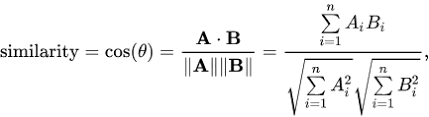

In [8]:
# Item Similarity Matrix
item_item = cosine_similarity(user_item_norm.T)
item_item = pd.DataFrame(item_item, index= user_item.columns, columns=user_item.columns)
item_item.head()

tag_id,00410345e6d60633a211ebd3755d5c89ea7b5297,005703ee98894846cde759fbe88f3d7fde830c85,0076e2a45d90991150032dbfaa574b4b7ab21177,0087f6286f5bd4f872620555b3e3b880e21de444,008a19c4e6b27ade78d422f9deaba16ef195772b,0108e35fbb3bb7e60c2045386294914255f137eb,01c1f1173136b005f885c4691db374d4762f15e0,022f8f30c65aaeb13def1fb9d700c1937e30da06,0245aa04713eb538ebcb6d6c5667a55f5920d535,02a5da421359cb69816444a48f35c0cb01806ca6,...,fde652531ae50c7def995f5c5c2b067cd9bdc9de,fe0f9fd1fdfe652523ed4a3a9e57375301bf7144,fe2297da6fbc7992a934f8ce4c848584d73bd1c3,fe5cd317975ca5dada3d9d047133f1925e460053,fe9cd8d22101c48eca5bc3eee51b9dc5e07fe683,fe9e7151b6ae2070c053a80fa37862cfef449cae,fed8505b88adf6d879b4df147b29a068d98faa72,ff0257af2bc7c28cd397a820aa33cde0d04b58b8,ff0d3fb21c00bc33f71187a2beec389e9eff5332,ff664fdace0b1f85828387e81580f871eacb6386
tag_id,,,,,,,,,,,,,,,,,,,,,
00410345e6d60633a211ebd3755d5c89ea7b5297,1.000000,0.0,0.027659,0.0,0.000000,0.0,0.018121,0.000000,0.0,0.011351,...,0.0,0.000000,0.011971,0.004901,0.0,0.000000,0.000000,0.000000,0.000000,0.0
005703ee98894846cde759fbe88f3d7fde830c85,0.000000,1.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
0076e2a45d90991150032dbfaa574b4b7ab21177,0.027659,0.0,1.000000,0.0,0.028854,0.0,0.052853,0.058419,0.0,0.033109,...,0.0,0.019334,0.034916,0.014294,0.0,0.018493,0.000000,0.000000,0.000000,0.0
0087f6286f5bd4f872620555b3e3b880e21de444,0.000000,0.0,0.000000,1.0,0.000000,0.0,0.000000,0.005391,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.023841,0.053486,0.000000,0.0
008a19c4e6b27ade78d422f9deaba16ef195772b,0.000000,0.0,0.028854,0.0,1.000000,0.0,0.000000,0.005817,0.0,0.000000,...,0.0,0.021562,0.000000,0.000000,0.0,0.046702,0.000000,0.000000,0.037532,0.0


Once item-item similarity matrix is obtained, it is possible to make some predictions. Specifically, we will compute the rating of every user in train set for each item

In [9]:
item_prediction = user_item_norm.dot(item_item) / (np.array([np.abs(item_item).sum(axis=1)]) + 10e-9)
item_prediction = pd.DataFrame(item_prediction, index= user_item.index, columns=user_item.columns)

Let's see what items we recommend to the first user.
To do this:
    - We order user vector ratings
    - Compare items that user has already liked and delete them
    - Recommend 10 items for user

In [10]:
user = '00000055a78bf6735c4a89358fab1de34104c3cb'
items = item_prediction.columns.values
items_train = train_data.loc[train_data['user_id'] == user, 'tag_id'].values    
index_items_train = np.argwhere(np.isin(items, items_train)).flatten()
items_test = test_data.loc[test_data['user_id'] == user, 'tag_id'].values
index_items_test = np.argwhere(np.isin(items, items_test)).flatten()

prediction_user = item_prediction.loc[user, :].values
sort_index_prediction = np.argsort(prediction_user)[::-1]

index_items_top_predicted = sort_index_prediction[~np.isin(sort_index_prediction, index_items_train)][:10]
items_top_predicted = items[index_items_top_predicted]

Let's print items recommended and items that user has in test set

In [11]:
print('items recommended:')
print(items_top_predicted)
print()
print('items in test:')
print(items_test)

items recommended:
['5c61cd1b82ec7a4d2918a6de99fcd1577b462f79'
 '642b8a4788b43df14fccc16ba2c926c1a42a736f'
 '8378136c6dd0e03be859a210a0cee03955951fb1'
 'e78de9dad70d230a096f0bbdc3e89b5cae04ba77'
 '03dd382ae49f2579667496e58e1686f7d9ad58ce'
 'e07803b0cd21e9ad8dd4fbd12985e4359da5436a'
 'c7a0a83939c8dd0f10bde2b8162196c39049c41f'
 '89de5215045c7c53e27afd5e7e872a60ce49fa1b'
 '17e899eebd1a5d51fb708c6afff76c03bcf1d635'
 '51ca7b72b7dcd53989f97340b591d4b32e47c2b7']

items in test:
['e78de9dad70d230a096f0bbdc3e89b5cae04ba77'
 'b9a521730141de9bc4fe8ebc9f33713411d0101a'
 '8378136c6dd0e03be859a210a0cee03955951fb1'
 '5c61cd1b82ec7a4d2918a6de99fcd1577b462f79'
 'c093b1743115b3f9d368b2f7bdf54f367afccc7c']


We can see that items :
    - 'e78de9dad70d230a096f0bbdc3e89b5cae04ba77' 
    - '5c61cd1b82ec7a4d2918a6de99fcd1577b462f79' 
    - '8378136c6dd0e03be859a210a0cee03955951fb1'
are well recommended. 

So, te recall for this user is:
    - recall = true_positive / (true_positive + false_negative) = 3 / 5 = 0.6
    
We will not calculate precision because if we recommend 10 items and in test any user has less than 10 items precision will be small.

Next step is make the same computation for all users

In [12]:
# Get lists of items, users in test and users in train
items = item_prediction.columns.values
users_test = test_data['user_id'].unique()
users_train = train_data['user_id'].unique()

In [13]:
# Create recommendations and compute recall
tp = 0
fn = 0

for user in users_test:
    if user not in users_train:
        continue
        
    items_train = train_data.loc[train_data['user_id'] == user, 'tag_id'].values    
    index_items_train = np.argwhere(np.isin(items, items_train)).flatten()
    items_test = test_data.loc[test_data['user_id'] == user, 'tag_id'].values
    index_items_test = np.argwhere(np.isin(items, items_test)).flatten()
    
    prediction_user = item_prediction.loc[user, :].values
    sort_index_prediction = np.argsort(prediction_user)[::-1]
    index_items_top_predicted = sort_index_prediction[~np.isin(sort_index_prediction, index_items_train)][:10]
    items_top_predicted = items[index_items_top_predicted]
    
    tp += np.isin(index_items_top_predicted, index_items_test).sum()
    fn += (~np.isin(index_items_test, index_items_top_predicted)).sum()
    
recall = tp / (tp+fn)

print('Recall of model is: ' + str(recall))

Recall of model is: 0.22813299232736572


## 3 - Model based approach: Using Implicit package. Alternative Least Squares for Matrix factorization

ALS is an iterative optimization process to factorize a matrix.

In this case, we will factorize user-item matrix(R) with dimensions (u,i) and obtain two matrix with U(users) and V(items) where R ≈ U x V

Resulting matrix U will have dimensions (u, k) and V will have dimensions (k, i). This number k are the latent factors als algorithm

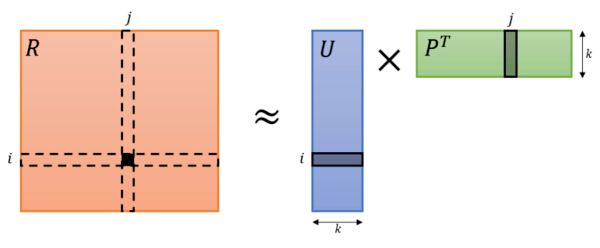

In this section we will use, implicit package to make factorization matrix with ALS algorithm, and to make recommendations. <br>
To create ALS model it is necessary to define:
    - number of latent factors (k)
    - confidence factor (alpha_val)
In this case we will realize the first run with:
    - k = 20
    - alpha_val = 40

In [14]:
# Create sparse matrix
sparse_user_item = sparse.csr_matrix(user_item_norm)
sparse_item_user = sparse.csr_matrix(user_item_norm.T)

# Initialize the model ALS
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=20)

# Multiply matrix by confidence
alpha_val = 40
data_conf = (sparse_item_user * alpha_val)

# Fit model
model.fit(data_conf)

# Create recommendations and compute recall
tp = 0
fn = 0

for user in users_test:
    if user not in users_train:
        continue
    
    items_test = test_data.loc[test_data['user_id'] == user, 'tag_id'].values
    index_items_test = np.argwhere(np.isin(items, items_test)).flatten()
    
    idx = np.argwhere(users_train == user)[0][0]
    model.recommend(idx, sparse_user_item, N=10)
    index_items_top_predicted = model.recommend(idx, sparse_user_item, N=10)
    index_items_top_predicted = [ind for ind, scr in index_items_top_predicted]
    
    tp += np.isin(index_items_top_predicted, index_items_test).sum()
    fn += (~np.isin(index_items_test, index_items_top_predicted)).sum()
    
recall = tp / (tp+fn)

print('Recall of model is: ' + str(recall))

100%|██████████| 20.0/20 [00:00<00:00, 21.36it/s]


Recall of model is: 0.23529411764705882


As we can see, we obtain a better recall.<br><br>
Now it's time to make hyperparameter tunning to get the best values for k and alpha_val<br>
We will make a search grid with:
    - k = [10, 20, 30, 40, 50, 100]
    - alpha_val = [15, 20, 30, 40, 50]

In [15]:
# Create sparse matrix
list_factors = [10, 20, 30, 40, 50, 100]
list_alpha_val = [15, 20, 30, 40, 50]

gridsearch_params = [
    (factors, alpha_val)
    for factors in list_factors
    for alpha_val in list_alpha_val]

for factors, alpha_val in gridsearch_params:
    print("CV with factors={}, alpha_val={}".format(factors, alpha_val))
    
    # Initialize the model ALS
    model = implicit.als.AlternatingLeastSquares(factors=factors, regularization=0.1, iterations=20)

    # Multiply matrix by confidence
    data_conf = (sparse_item_user * alpha_val)

    # Fit model
    model.fit(data_conf)
    
    # Create recommendations and compute recall
    tp = 0
    fn = 0
    for user in users_test:
        if user not in users_train:
            continue

        items_test = test_data.loc[test_data['user_id'] == user, 'tag_id'].values
        index_items_test = np.argwhere(np.isin(items, items_test)).flatten()

        idx = np.argwhere(users_train == user)[0][0]
        model.recommend(idx, sparse_user_item, N=10)
        index_items_top_predicted = model.recommend(idx, sparse_user_item, N=10)
        index_items_top_predicted = [ind for ind, scr in index_items_top_predicted]

        tp += np.isin(index_items_top_predicted, index_items_test).sum()
        fn += (~np.isin(index_items_test, index_items_top_predicted)).sum()

    recall = tp / (tp+fn)

    print('Recall of model is: ' + str(recall))

CV with factors=10, alpha_val=15


100%|██████████| 20.0/20 [00:00<00:00, 29.56it/s]


Recall of model is: 0.2020460358056266
CV with factors=10, alpha_val=20


100%|██████████| 20.0/20 [00:00<00:00, 29.78it/s]


Recall of model is: 0.19130434782608696
CV with factors=10, alpha_val=30


100%|██████████| 20.0/20 [00:00<00:00, 25.34it/s]


Recall of model is: 0.19130434782608696
CV with factors=10, alpha_val=40


100%|██████████| 20.0/20 [00:00<00:00, 20.94it/s]


Recall of model is: 0.18721227621483377
CV with factors=10, alpha_val=50


100%|██████████| 20.0/20 [00:00<00:00, 24.62it/s]


Recall of model is: 0.20153452685421994
CV with factors=20, alpha_val=15


100%|██████████| 20.0/20 [00:00<00:00, 22.76it/s]


Recall of model is: 0.22813299232736572
CV with factors=20, alpha_val=20


100%|██████████| 20.0/20 [00:01<00:00, 15.02it/s]


Recall of model is: 0.239386189258312
CV with factors=20, alpha_val=30


100%|██████████| 20.0/20 [00:01<00:00, 18.89it/s]


Recall of model is: 0.23785166240409208
CV with factors=20, alpha_val=40


100%|██████████| 20.0/20 [00:01<00:00, 17.01it/s]


Recall of model is: 0.23836317135549873
CV with factors=20, alpha_val=50


100%|██████████| 20.0/20 [00:00<00:00, 21.85it/s]


Recall of model is: 0.23375959079283887
CV with factors=30, alpha_val=15


100%|██████████| 20.0/20 [00:01<00:00, 13.17it/s]


Recall of model is: 0.2608695652173913
CV with factors=30, alpha_val=20


100%|██████████| 20.0/20 [00:01<00:00, 14.54it/s]


Recall of model is: 0.2572890025575448
CV with factors=30, alpha_val=30


100%|██████████| 20.0/20 [00:01<00:00, 15.23it/s]


Recall of model is: 0.2659846547314578
CV with factors=30, alpha_val=40


100%|██████████| 20.0/20 [00:01<00:00, 13.98it/s]


Recall of model is: 0.2618925831202046
CV with factors=30, alpha_val=50


100%|██████████| 20.0/20 [00:01<00:00, 14.65it/s]


Recall of model is: 0.25882352941176473
CV with factors=40, alpha_val=15


100%|██████████| 20.0/20 [00:01<00:00, 15.09it/s]


Recall of model is: 0.27877237851662406
CV with factors=40, alpha_val=20


100%|██████████| 20.0/20 [00:01<00:00, 13.44it/s]


Recall of model is: 0.27570332480818416
CV with factors=40, alpha_val=30


100%|██████████| 20.0/20 [00:01<00:00, 12.28it/s]


Recall of model is: 0.2777493606138107
CV with factors=40, alpha_val=40


100%|██████████| 20.0/20 [00:02<00:00,  8.90it/s]


Recall of model is: 0.2675191815856777
CV with factors=40, alpha_val=50


100%|██████████| 20.0/20 [00:01<00:00, 12.70it/s]


Recall of model is: 0.27621483375959077
CV with factors=50, alpha_val=15


100%|██████████| 20.0/20 [00:01<00:00, 11.97it/s]


Recall of model is: 0.2849104859335038
CV with factors=50, alpha_val=20


100%|██████████| 20.0/20 [00:01<00:00, 12.11it/s]


Recall of model is: 0.28695652173913044
CV with factors=50, alpha_val=30


100%|██████████| 20.0/20 [00:01<00:00, 12.17it/s]


Recall of model is: 0.28081841432225063
CV with factors=50, alpha_val=40


100%|██████████| 20.0/20 [00:01<00:00, 12.32it/s]


Recall of model is: 0.28286445012787725
CV with factors=50, alpha_val=50


100%|██████████| 20.0/20 [00:01<00:00, 11.57it/s]


Recall of model is: 0.28337595907928387
CV with factors=100, alpha_val=15


100%|██████████| 20.0/20 [00:01<00:00, 11.08it/s]


Recall of model is: 0.2772378516624041
CV with factors=100, alpha_val=20


100%|██████████| 20.0/20 [00:01<00:00, 11.14it/s]


Recall of model is: 0.2813299232736573
CV with factors=100, alpha_val=30


100%|██████████| 20.0/20 [00:01<00:00, 11.39it/s]


Recall of model is: 0.2813299232736573
CV with factors=100, alpha_val=40


100%|██████████| 20.0/20 [00:01<00:00, 11.28it/s]


Recall of model is: 0.28388746803069054
CV with factors=100, alpha_val=50


100%|██████████| 20.0/20 [00:01<00:00, 11.55it/s]


Recall of model is: 0.2792838874680307


Results are improved, so the best model is:
- Recall of model is: 0.28695652173913044
- CV with factors=50, alpha_val=30

## 4 - Conclusions

** Memory based approach: Item-item collaborative filtering **
    - Recall = 0.228132

** Model based approach: Item-item with ALS matrix factorization **
    - Recall = 0.286956
    
As we can see Model based approach is better than memory based. <br>
So, we take this model to recommend 10 similar items to item of tag: 'ff0d3fb21c00bc33f71187a2beec389e9eff5332'

In [16]:
# n_similar items
n_similar = 11

# Get index of 'ff0d3fb21c00bc33f71187a2beec389e9eff5332' in original dataset
item_idx = np.argwhere(user_item.columns == 'ff0d3fb21c00bc33f71187a2beec389e9eff5332')[0][0]

# Initialize the model ALS
factors = 50
alpha_val = 30
model = implicit.als.AlternatingLeastSquares(factors=factors, regularization=0.1, iterations=20)

# Multiply matrix by confidence
data_conf = (sparse_item_user * alpha_val)

# Fit model
model.fit(data_conf)

# Use implicit to get similar items.
similar = model.similar_items(item_idx, n_similar)

# Print top 10 similar items
for item in similar[1:]:
    idx, score = item
    print(user_item.columns[idx])

100%|██████████| 20.0/20 [00:01<00:00, 12.33it/s]


7ee223009403f7450993fe5d79516f1fc841e75e
340f1eaf7ad0c07f1491338ab68cbcab30c315ec
6b0cd6a8094daf42e766ea257a2af3571831bb32
5384b5d2fa98888387e27e9f41c103ec331f00d7
bdf147e99ee57500eb2dabcbf3cfa24e1daef357
820c2fc67b01d3a53750c21eab0a4edb1dc0a422
0d3dc58ead1aa17dcc7d6481215d0e940f1cedad
4f9ffe0ec421659b5417381e12c57716f7d6f2c9
1a0e2f8e2e7e4f748ea60419ec6ba9cd4be2dc49
aa714218e66a8101278c5f0a0991b5bd8021bac6
